# ViT: Transformer for Image Recognition at Scale

In [ ]:
import torch
import torch.nn as nn
from collections import OrderedDict
import matplotlib.pyplot as plt
from train import evaluate_model, train_model, get_dataset, get_model 


# Train the Model on CIFAR-10

### Load Custiom ViT model

In [ ]:
def get_config():
    return {
        "batch_size": 64,
        "img_size" : 224,
        "patch_size" : 16,
        "in_channels" : 3,
        "d_model" : 768,
        "d_ff" : 3072,
        "dropout" : 0.1,
        "num_heads": 8,
        "num_layers": 12,
        "num_epochs": 15,
        "lr": 10**-4,
        "model_folder": "/weights",
        "model_basename": "vitmodel_",
        "preload": "13",
        "experiment_name": "/runs/vitmodel",
    }

In [ ]:
config = get_config()
model = get_model(config, 10)
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-11): 12 x EncoderBlock(
        (self_attention_block): MultiHeadAttentionBlock(
          (w_q): Linear(in_features=768, out_features=768, bias=True)
          (w_k): Linear(in_features=768, out_features=768, bias=True)
          (w_v): Linear(in_features=768, out_features=768, bias=True)
          (w_o): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward_block): FeedForwardBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (activation): GELU(approximate='none')
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (residual_connection): ModuleList(
          (0-1): 2 x ResidualConnection(
     

In [ ]:
# warnings.filterwarnings("ignore")
train_model(model, config)

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Preloading model: /weights/vitmodel_13.pt


Epoch [14/15]: 100%|██████████| 782/782 [15:49<00:00,  1.21s/it, accuracy=76.80, loss=0.786]


/weights/vitmodel_14.pt


### Evaluate the Model

In [ ]:
train_loader, test_loader = get_dataset(config)

evaluate_model(model, test_loader)

Evaluating: 100%|██████████| 157/157 [01:00<00:00,  2.59it/s]

Test Loss: 0.9756, Test Accuracy: 68.70%


68.7

tensor(3, device='cuda:0')
tensor(8, device='cuda:0')
tensor(8, device='cuda:0')
tensor(0, device='cuda:0')
tensor(6, device='cuda:0')


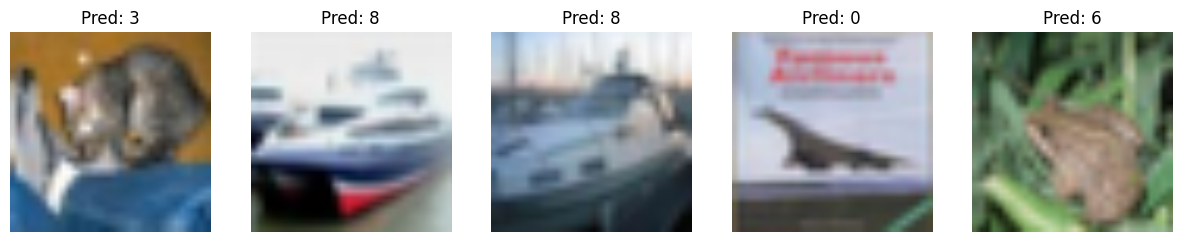

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    predictions = outputs.argmax(dim=1)  # predicted class

# convert image to (H, W, C) format for visualization
def unnormalize(img):
    """ Convert normalized image back to [0, 1] range for display. """
    img = img.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    img = img * 0.5 + 0.5  # reverse normalization
    img = img.clip(0, 1)  # ensure valid range
    return img

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    axes[i].imshow(unnormalize(images[i]))
    axes[i].set_title(f"Pred: {predictions[i].item()}")
    axes[i].axis("off")
    print(labels[i])

plt.show()


# Transfer Learning with pretrained model weights on ImageNet-1k

In [5]:
!pip install transformers

### Load Custiom ViT model for transfer learning

In [ ]:
def get_hf_config():
    return {
        "batch_size": 64,
        "img_size" : 224,
        "patch_size" : 16,
        "in_channels" : 3,
        "d_model" : 768,
        "d_ff" : 3072,
        "dropout" : 0.1,
        "num_heads": 12,
        "num_layers": 12,
        "num_epochs": 1,
        "lr": 10**-4,
        "model_folder": "/weights",
        "model_basename": "tf_vitmodel_",
        "preload": None,
        "experiment_name": "/runs/tf_vitmodel",
    }

In [ ]:
config = get_hf_config()
vit_model = get_model(config, 10)

### Mapping HuggingFace model to Custion ViT Model

In [ ]:
from transformers import ViTForImageClassification

# load pretrained model (ImageNet-1k, 1000 classes)
hf_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
# adapt the num_classes for CIFAR-10 dataset
hf_model.classifier = nn.Linear(hf_model.classifier.in_features, 10)

# parameter mapping from huggingface model to custom vit model
hf_state_dict = hf_model.state_dict()
new_state_dict = OrderedDict()

for k, v in hf_state_dict.items():
    new_k = k

    # patch embedding
    new_k = new_k.replace("vit.embeddings.patch_embeddings.projection", "patch_embed.proj")
    new_k = new_k.replace("vit.embeddings.position_embeddings", "patch_embed.pos_embedding")
    new_k = new_k.replace("vit.embeddings.cls_token", "patch_embed.cls_token")

    # Transformer encoder layers
    new_k = new_k.replace("vit.encoder.layer.", "encoder.layers.")
    new_k = new_k.replace(".attention.attention.query", ".self_attention_block.w_q")
    new_k = new_k.replace(".attention.attention.key", ".self_attention_block.w_k")
    new_k = new_k.replace(".attention.attention.value", ".self_attention_block.w_v")
    new_k = new_k.replace(".attention.output.dense", ".self_attention_block.w_o")

    new_k = new_k.replace(".intermediate.dense", ".feed_forward_block.linear_1")
    new_k = new_k.replace(".output.dense", ".feed_forward_block.linear_2")

    new_k = new_k.replace(".layernorm_before", ".residual_connection.0.norm")
    new_k = new_k.replace(".layernorm_after", ".residual_connection.1.norm")

    # final Layer Norm
    new_k = new_k.replace("vit.layernorm", "encoder.norm")

    new_k = new_k.replace("classifier", "mlp_head")

    # skip any keys not relevant to custom vit model
    if "pooler" in k:
        continue

    new_state_dict[new_k] = v

# load the remapped weights into custom vit model
missing, unexpected = vit_model.load_state_dict(new_state_dict, strict=False)

print(f"Missing keys: {missing}")
print(f"Unexpected keys: {unexpected}")


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Missing keys: []
Unexpected keys: []


### Model Comparison

In [29]:
hf_model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [9]:
vit_model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-11): 12 x EncoderBlock(
        (self_attention_block): MultiHeadAttentionBlock(
          (w_q): Linear(in_features=768, out_features=768, bias=True)
          (w_k): Linear(in_features=768, out_features=768, bias=True)
          (w_v): Linear(in_features=768, out_features=768, bias=True)
          (w_o): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward_block): FeedForwardBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (activation): GELU(approximate='none')
          (dropout): Dropout(p=0.1, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (residual_connection): ModuleList(
          (0-1): 2 x ResidualConnection(
     

## Finu-tune the Model

### Before Finu-tuning

In [ ]:
evaluate_model(vit_model, test_loader)

Evaluating: 100%|██████████| 157/157 [01:02<00:00,  2.52it/s]

Test Loss: 2.5852, Test Accuracy: 3.79%


3.79

In [ ]:
train_model(vit_model, config)

Using device: cuda


100%|██████████| 170M/170M [00:11<00:00, 14.8MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Epoch [00/1]: 100%|██████████| 782/782 [15:24<00:00,  1.18s/it, accuracy=95.94, loss=0.012]


/weights/tf_vitmodel_00.pt


### After Finu-tuning

In [ ]:
evaluate_model(vit_model, test_loader)

Files already downloaded and verified
Files already downloaded and verified
Using device: cuda


Evaluating: 100%|██████████| 157/157 [01:03<00:00,  2.47it/s]

Test Loss: 0.0699, Test Accuracy: 97.90%


97.9